# **GPU Setup**

In [1]:
import tensorflow as tf


device_name = tf.test.gpu_device_name()


if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:

    print("GPU device not found")

Found GPU at: /device:GPU:0


In [2]:
import torch


if torch.cuda.is_available():    

    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))


else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


# **Hugging Face Library**

In [3]:
!pip install transformers
!pip install datasets

# **Loading STSB Dataset**

In [4]:
from datasets import load_dataset

stsb = load_dataset('glue', 'stsb')

Reusing dataset glue (/root/.cache/huggingface/datasets/glue/stsb/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
stsb

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 5749
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1500
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1379
    })
})

In [6]:
stsb["train"]

Dataset({
    features: ['sentence1', 'sentence2', 'label', 'idx'],
    num_rows: 5749
})

In [7]:
import pandas as pd

train_df = pd.DataFrame.from_dict(stsb["train"])

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(train_df.shape[0]))

# Display 10 random rows from the data.
train_df.sample(10)

Number of training sentences: 5,749



,sentence1,sentence2,label,idx
5142,Italian Foreign Minister confers with Ghana VP,Belgian Prime Minister sends condolences to vi...,0.200,5142
1944,Scuba diver submerged in water.,The scuba diver is underwater.,5.000,1944
217,A boy is playing a key-board.,A boy is playing the piano.,3.200,217
256,A man is cutting tomatoes into pieces.,A woman is cutting some vegetables.,1.800,256
601,A man is driving a car.,A man drives a car.,4.875,601
2446,That is not direct responsibilty to the consti...,Aye but they ARE responsible to their constitu...,2.600,2446
419,A cat is sliding upside down under a couch.,A cat is crawling under a piece of furniture o...,3.200,419
2581,Neither military action nor large-scale briber...,"Indeed, Wolfowitz admitted Saturday that neith...",3.000,2581
2834,The Institute for Supply Management's index of...,The Institute for Supply Management said its i...,3.400,2834
1419,Boy laying on couch with dog.,The boy is lying on a couch with a puppy.,4.400,1419


In [8]:
val_df = pd.DataFrame.from_dict(stsb["validation"])

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(val_df.shape[0]))

# Display 10 random rows from the data.
val_df.sample(10)

Number of training sentences: 1,500



,sentence1,sentence2,label,idx
1213,The company said it would cut the wholesale pr...,The company also said it would cut wholesale p...,1.60,1213
1240,Net revenue rose to $3.99 billion from $3.85 b...,That is up from $1.14 billion during the same ...,1.75,1240
1167,The Dow Jones Industrial Average fell 0.7 per ...,The Dow Jones industrial average <.DJI> fell 4...,1.50,1167
1288,Spanish jobless rate soars past 25 per cent,"US jobless rate seen rising, offering Obama no...",1.00,1288
500,Our current vehicles will be in museums when e...,The car needs to some work,0.20,500
137,A woman is putting on sun glasses.,A woman puts on sunglasses.,5.00,137
558,A little girl and boy are reading books.,An older child is playing with a doll while ga...,0.20,558
1023,The Standard & Poor's 500 stock index ended th...,"The Standard and Poor's 500-stock index, a bro...",3.20,1023
662,It's pretty difficult to imagine a person with...,"On the surface, it does seem like social anxie...",4.20,662
186,A woman is cutting potato.,A woman is riding a horse.,0.75,186


In [9]:
# Get the lists of sentences and their labels.
train_sentences1 = train_df.sentence1.values
train_sentences2 = train_df.sentence2.values
train_labels = train_df.label.values

val_sentences1 = val_df.sentence1.values
val_sentences2 = val_df.sentence2.values
val_labels = val_df.label.values

# **Bert Tokenizer**

In [10]:
from transformers import BertTokenizer

print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [11]:
print(' Original: ', train_sentences1[0])

 Original:  A plane is taking off.


In [12]:
print('Tokenized: ', tokenizer.tokenize(train_sentences1[0]))

Tokenized:  ['a', 'plane', 'is', 'taking', 'off', '.']


In [13]:
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_sentences1[0])))

Token IDs:  [1037, 4946, 2003, 2635, 2125, 1012]


## **Tokenize Dataset**

In [14]:
max_len = 0

# For every sentence...
for sent1, sent2 in zip(train_sentences1, train_sentences2):

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent1, sent2, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length in train: ', max_len)

Max sentence length in train:  125


In [15]:
max_len = 0

# For every sentence...
for sent1, sent2 in zip(val_sentences1, val_sentences2):

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent1, sent2, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length in validation: ', max_len)

Max sentence length in validation:  87


In [16]:
def encode(sentences1, sentences2, labels):
  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []

  # For every pair of sentences...
  for sent1, sent2 in zip(sentences1, sentences2):

      encoded_dict = tokenizer.encode_plus(
                          sent1,                      # Sentence1 to encode.
                          sent2,                      # Sentence2 to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 128,           # Pad & truncate all sentences.
                          pad_to_max_length = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )
      
      # Add the encoded sentence to the list.    
      input_ids.append(encoded_dict['input_ids'])
      
      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

  return input_ids, attention_masks, labels


train_input_ids, train_attention_masks, train_labels = encode(train_sentences1, train_sentences2, train_labels)
val_input_ids, val_attention_masks, val_labels = encode(val_sentences1, val_sentences2, val_labels)


# Print sentence 0 in train, now as a list of IDs.
print('Original: ', train_sentences1[0] ,train_sentences2[0])
print('Token IDs:', train_input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  A plane is taking off. An air plane is taking off.
Token IDs: tensor([ 101, 1037, 4946, 2003, 2635, 2125, 1012,  102, 2019, 2250, 4946, 2003,
        2635, 2125, 1012,  102,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])


In [17]:
from torch.utils.data import TensorDataset

# Combine the training inputs into a TensorDataset.
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)

# **Data Loader**

In [18]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )


validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# **Train The Model**

In [19]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 1, # The number of output labels--1 for regression.  
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)


model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [20]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [21]:
# Freeze all layers except classifier

for name, param in model.named_parameters():
  if 'classifier' in name or 'bert.pooler.dense' in name:
    param.requires_grad = True
  else:
    param.requires_grad = False

## **Optimizer & Learning Rate Scheduler**

In [22]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5.
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [23]:
import torch.nn as nn

# Loss function
criterion = nn.MSELoss()

In [24]:
from transformers import get_linear_schedule_with_warmup


epochs = 10

total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## **Train Loop**

In [25]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [26]:
import random
import numpy as np


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode.
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))


 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        batch[2] = torch.reshape(batch[2], (-1,1))
        # print("labels size: ", batch[2].size())
        b_labels = batch[2].to(device)


        model.zero_grad()        


        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        # loss = result.loss
        logits = result.logits

        loss = criterion(logits.float(), b_labels.float())
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # print('--------------------------------')

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        batch[2] = torch.reshape(batch[2], (-1,1))
        # print("labels size: ", batch[2].size())
        b_labels = batch[2].to(device)
        

        with torch.no_grad():        


            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)


        logits = result.logits

        loss = criterion(logits.float(), b_labels.float())

            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()


    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 10 ========
Training...
  Batch    40  of    180.    Elapsed: 0:00:11.
  Batch    80  of    180.    Elapsed: 0:00:22.
  Batch   120  of    180.    Elapsed: 0:00:33.
  Batch   160  of    180.    Elapsed: 0:00:43.

  Average training loss: 2.79
  Training epcoh took: 0:00:48

Running Validation...
  Validation Loss: 2.12
  Validation took: 0:00:12

======== Epoch 2 / 10 ========
Training...
  Batch    40  of    180.    Elapsed: 0:00:10.
  Batch    80  of    180.    Elapsed: 0:00:20.
  Batch   120  of    180.    Elapsed: 0:00:31.
  Batch   160  of    180.    Elapsed: 0:00:41.

  Average training loss: 1.85
  Training epcoh took: 0:00:46

Running Validation...
  Validation Loss: 2.16
  Validation took: 0:00:12

======== Epoch 3 / 10 ========
Training...
  Batch    40  of    180.    Elapsed: 0:00:10.
  Batch    80  of    180.    Elapsed: 0:00:21.
  Batch   120  of    180.    Elapsed: 0:00:31.
  Batch   160  of    180.    Elapsed: 0:00:42.

  Average training loss: 1.74
 

In [27]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,2.79,2.12,0:00:48,0:00:12
2,1.85,2.16,0:00:46,0:00:12
3,1.74,2.16,0:00:47,0:00:12
4,1.66,2.11,0:00:47,0:00:12
5,1.63,2.07,0:00:47,0:00:12
6,1.58,2.08,0:00:47,0:00:12
7,1.57,2.06,0:00:47,0:00:12
8,1.54,2.02,0:00:47,0:00:12
9,1.54,2.03,0:00:47,0:00:12


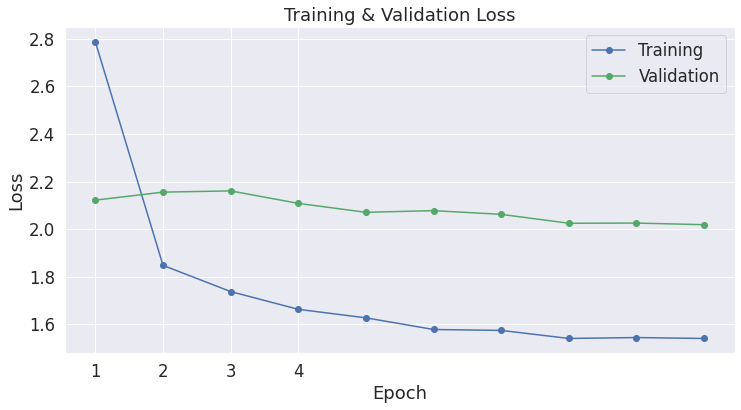

In [28]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()